In [24]:
import matplotlib.pyplot as plt
import json
from run import run as run_lca
from run_baseline import run as run_baseline
from tools import *
from init_logger import init_logger
import os
import ga_driver
import numpy as np
import exp_scores as es
import gamma_scores as gs

In [26]:
config = get_config("configs/config_forestelephants.yaml")
lca_config = config['lca']
db_path = os.path.join(lca_config['db_path'], config['exp_name'])

verifier_file =  os.path.join(db_path, "verifiers_probs.json")
wgtrs_calib_dict = load_json(verifier_file)
lca_params = generate_ga_params(lca_config)
probs = wgtrs_calib_dict['miewid']
wgtrs = ga_driver.generate_weighters(
            lca_params, wgtrs_calib_dict
        )
scorer = es.exp_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )
scorer = gs.gamma_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )

In [27]:
pos_scores = probs["gt_positive_probs"]
neg_scores = probs["gt_negative_probs"]

In [21]:
%load_ext autoreload
%autoreload 2
from preprocess import preprocess_data
from embeddings import Embeddings
from curate_using_LCA import curate_using_LCA, generate_wgtr_calibration_ground_truth
from tools import *
import random
import os
from cluster_validator import ClusterValidator

lca_config = config['lca']
data_params = config['data']
lca_params = generate_ga_params(lca_config)

embeddings, uuids = load_pickle(data_params['embedding_file'])

#create db files

db_path = os.path.join(lca_config['db_path'], config['exp_name'])
os.makedirs(db_path, exist_ok=True)

verifier_file =  os.path.join(db_path, "verifiers_probs.json")
edge_db_file =  os.path.join(db_path, "quads.csv")
clustering_file = os.path.join(db_path, "clustering.json")
autosave_file = os.path.join(db_path, "autosave.json")

lca_params['autosave_file'] = autosave_file


# preprocess data

name_keys = data_params['name_keys']
filter_key = '__'.join(name_keys)
df = preprocess_data(data_params['annotation_file'], 
                    name_keys= name_keys,
                    convert_names_to_ids=True, 
                    viewpoint_list=data_params['viewpoint_list'], 
                    n_filter_min=data_params['n_filter_min'], 
                    n_filter_max=data_params['n_filter_max'],
                    images_dir = data_params['images_dir'], 
                    embedding_uuids = uuids
                )

print_intersect_stats(df, individual_key=filter_key)


# create cluster validator
filtered_df = df[df['uuid_x'].isin(uuids)]
embeddings = [embeddings[uuids.index(uuid)] for uuid in filtered_df['uuid_x']]
gt_clustering, gt_node2cid, node2uuid = generate_gt_clusters(filtered_df, filter_key)
cluster_validator = ClusterValidator(gt_clustering, gt_node2cid)
ga_driver.set_validator_functions(cluster_validator.trace_start_human, cluster_validator.trace_iter_compare_to_gt)


# create embeddings verifier
print(len(node2uuid.keys()))
print(len(embeddings))
verifier_embeddings = Embeddings(embeddings, list(node2uuid.keys()), distance_power=lca_params['distance_power'])
verifier_edges = verifier_embeddings.get_edges()

# create human reviewer

prob_human_correct = lca_params['prob_human_correct']
    
human_reviewer = call_get_reviews(df, filter_key, prob_human_correct)
num_pos_needed = lca_params['num_pos_needed']
num_neg_needed = lca_params['num_neg_needed']


pos, neg, quit = generate_wgtr_calibration_ground_truth(verifier_edges, human_reviewer, num_pos_needed, num_neg_needed)

pos_scores = [s for (_, _, s) in pos]
neg_scores = [s for (_, _, s) in neg]

scorer = es.exp_scores.create_from_samples(
            pos_scores, neg_scores
        )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Merging on image uuid
** Loaded /ekaterina/work/data/elephants/forestelephants_query.json **
      Found 1282 annotations
      1282 annotations remain after filtering by given uuids
      1282 annotations remain after filtering by viewpoint list ['right', 'left']
      1210 annotations remain after filtering by min 2 per name__viewpoint
      1168 annotations remain after filtering by max 10 per name__viewpoint
1168
1168
Calculating distances...
1168/1168
Chunk result: 1.510708 seconds, Total estimate: 0.025179 minutes
Max dist: 0.6543114185333252
Calculated distances: 0.031156 seconds
13763


In [17]:
# pos_scores_all = []
# neg_scores_all = []
# edge_nodes = [(n1, n2) for (n1, n2, _) in verifier_edges]
# i = 0
# print("getting reviews")
# reviews, quit_lca = human_reviewer(edge_nodes)
# print("got")
# for ((_, _, b), (_, _, s)) in zip(reviews, verifier_edges):
#     if b:
#         pos_scores_all.append(s)
#     else:
#         neg_scores_all.append(s)
# print("fin")

(array([4.07687580e-03, 4.07687580e-02, 1.75305659e-01, 8.84682048e-01,
        2.43797173e+00, 5.53639733e+00, 8.14967472e+00, 8.67559170e+00,
        6.66569193e+00, 4.22772020e+00, 2.23005106e+00, 9.41758309e-01,
        1.26790837e+00, 2.50727862e+00, 2.58066238e+00, 1.64705782e+00,
        1.10483334e+00, 6.44146376e-01, 4.97378847e-01, 4.07687580e-01,
        4.68840717e-01, 3.79149449e-01, 4.23995083e-01, 4.15841331e-01,
        4.15841331e-01, 4.07687580e-01, 4.40302586e-01, 4.68840717e-01,
        4.15841331e-01, 4.60686965e-01, 3.75072573e-01, 2.89458182e-01,
        2.81304430e-01, 2.36458796e-01, 6.11531370e-02]),
 array([0.37685949, 0.3946635 , 0.41246751, 0.43027152, 0.44807553,
        0.46587954, 0.48368355, 0.50148757, 0.51929158, 0.53709559,
        0.5548996 , 0.57270361, 0.59050762, 0.60831163, 0.62611564,
        0.64391966, 0.66172367, 0.67952768, 0.69733169, 0.7151357 ,
        0.73293971, 0.75074372, 0.76854773, 0.78635175, 0.80415576,
        0.82195977, 0.8397

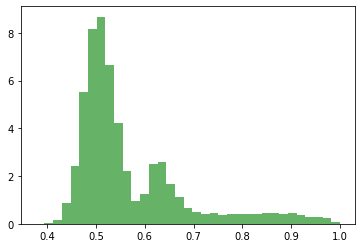

In [15]:
all_scores = [s for (_, _, s) in verifier_edges]

plt.hist(all_scores, bins=35, density=True, alpha=0.6, color='g')

# plt.hist(pos_scores_all, bins=35, density=True, alpha=0.6, color='g')
# plt.hist(neg_scores_all, bins=35, density=True, alpha=0.6, color='r')

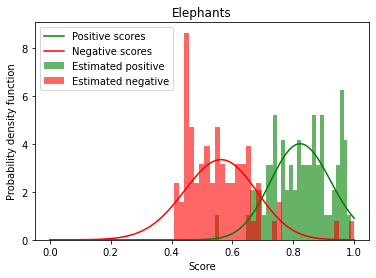

In [28]:
plt.hist(pos_scores, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg_scores, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)
pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]

plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')
# plt.title(title)

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Elephants")
plt.legend(["Positive scores", "Negative scores", "Estimated positive", "Estimated negative"])

In [20]:
len(neg_scores)

1375